Part1: Importing libs and reading the dataset

In [28]:
!pip install numpy pandas matplotlib seaborn kagglehub catboost scikit-learn duckdb
!pip install pyarrow
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.8/683.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [fastparquet]


This code below sets up a Python notebook environment for working with the Duolingo spaced-repetition dataset and then loads a first sample table for inspection. It imports a set of libraries for 
(1) core data wrangling (numpy, pandas), 
(2) time handling (datetime, timedelta), 
(3) filesystem scanning and memory management (os, glob, gc), 
(4) visualization (seaborn, matplotlib), 
(5) downloading the dataset from Kaggle (kagglehub),
 (6) text/tag processing (re, itertools.chain, collections.Counter), 
 (7) evaluation metrics (mean_squared_error, mean_absolute_error), and 
 (8) SQL-style analytics on large data (duckdb). 
 It then downloads the latest version of the Kaggle dataset aravinii/duolingo-spaced-repetition-data into a local cache directory, prints the resolved local path, recursively searches that directory for all .csv files, and prints the list of discovered CSV paths. Finally, it reads the first CSV file into a Pandas DataFrame (df) and displays the first few rows (df.head()) as a quick sanity check to confirm that the data was downloaded and parsed correctly.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os, glob, gc
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import re
from itertools import chain
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error
import duckdb
from catboost import CatBoostRegressor, Pool
import fastparquet

# Download latest version
path = kagglehub.dataset_download("aravinii/duolingo-spaced-repetition-data")

print("Path to dataset files:", path)

# 找到所有 CSV 文件
csv_files = []
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(root, f))

print("Found CSV files:", csv_files)


df = pd.read_csv(csv_files[0])
df.head()

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/dingchuangyu/.cache/kagglehub/datasets/aravinii/duolingo-spaced-repetition-data/versions/1
Found CSV files: ['/Users/dingchuangyu/.cache/kagglehub/datasets/aravinii/duolingo-spaced-repetition-data/versions/1/learning_traces.13m.csv']


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [2]:

df.isnull().sum()


p_recall             0
timestamp            0
delta                0
user_id              0
learning_language    0
ui_language          0
lexeme_id            0
lexeme_string        0
history_seen         0
history_correct      0
session_seen         0
session_correct      0
dtype: int64

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df["timestamp_dt"] = pd.to_datetime(df["timestamp"], unit="s")
df["delta_hours"] = df["delta"] / 3600
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")

In [5]:
df["tag_list"] = df["lexeme_string"].str.findall(r"<([^>]+)>")

In [ ]:
all_tags = sorted(set(chain.from_iterable(df["tag_list"])))
print(all_tags)


['*case', '*gndr', '*numb', '*pers', '*sf', '@adv:a_part', '@adv:a_peu_pres', '@adv:a_posteriori', '@adv:a_priori', '@adv:au_dela', '@adv:au_moins', '@adv:en_fait', '@adv:en_general', '@adv:peut_etre', '@adv:por_favor', '@adv:por_supuesto', '@adv:s_il_te_plait', '@adv:s_il_vous_plait', '@adv:tout_a_fait', '@cnj:alors_que', '@cnj:apres_que', '@cnj:autant_que', '@cnj:avant_que', '@cnj:bien_que', '@cnj:depuis_que', '@cnj:des_que', '@cnj:du_fait_que', '@cnj:parce_que', '@cnj:pendant_que', '@cnj:pour_que', '@cnj:tandis_que', '@common_phrases:a_bientot', '@common_phrases:a_demain', '@common_phrases:a_plus', '@common_phrases:a_plus_tard', '@common_phrases:ca_va_bien', '@common_phrases:comment_ca_va', '@common_phrases:de_rien', '@common_phrases:il_y_a', '@compound_past', '@cond', '@cond_perfect', '@det:a_le', '@det:de_le', '@formal', '@future', '@future_perfect', '@future_phrasal', '@ger_past', '@ij:au_revoir', '@ij:auf_wiedersehen', '@ij:bis_bald', '@ij:buenas_noches', '@ij:buenos_dias', '@ij

In [ ]:
df["n_skill"] = df["tag_list"].apply(lambda xs: sum(t.startswith("@") for t in xs))
print("rows with >=1 @skill:", (df["n_skill"] > 0).mean())

c = Counter(t for xs in df["tag_list"] for t in xs if isinstance(t,str) and t.startswith("@"))
print("n_unique @skills:", len(c))
print("top50:\n", c.most_common(50))



rows with >=1 @skill: 0.012559995238889867
n_unique @skills: 92
top50:
 [('@present_perfect', 25355), ('@future_phrasal', 18643), ('@future', 11807), ('@ij:thank_you', 10055), ('@past_perfect', 9078), ('@past', 8661), ('@adv:por_favor', 7182), ('@formal', 6740), ('@common_phrases:ca_va_bien', 6020), ('@ij:merci_beaucoup', 4530), ('@ij:buenas_noches', 3866), ('@ij:buenos_dias', 3790), ('@future_perfect', 3584), ('@modal', 3403), ('@cond_perfect', 3186), ('@itg:est_ce_que', 3160), ('@common_phrases:comment_ca_va', 2387), ('@adv:s_il_vous_plait', 1863), ('@common_phrases:a_demain', 1790), ('@ij:au_revoir', 1749), ('@adv:s_il_te_plait', 1676), ('@common_phrases:a_plus_tard', 1673), ('@common_phrases:il_y_a', 1654), ('@compound_past', 1545), ('@common_phrases:a_bientot', 1536), ('@common_phrases:de_rien', 1529), ('@common_phrases:a_plus', 1482), ('@ij:bis_bald', 1234), ('@ij:auf_wiedersehen', 1229), ('@itg:que_est_ce_que', 1034), ('@cond', 1007), ('@cnj:depuis_que', 889), ('@ref', 605), ('@

In [ ]:
tag_counts = (
    df["tag_list"]
    .explode()
    .value_counts()
    
)

print(tag_counts)

tag_list
sg                      7548428
n                       5480956
m                       2345375
pl                      2251963
vblex                   2235286
                         ...   
@adv:a_posteriori             6
@adv:a_priori                 6
@pos                          3
@obj                          1
@subjunctive_perfect          1
Name: count, Length: 179, dtype: int64


In [8]:
df["session_perfect"] = df["session_correct"] == df["session_seen"]
df["session_perfect"] = df["session_perfect"].astype(int)

The averge correct rate for english native

In [ ]:
# Restrict the analysis to users whose interface language is English
df_en = df[df["ui_language"] == "en"].copy()

In [ ]:
# Define a binary indicator of a "perfect" session:
# a session is considered perfect if all items seen in the session
# were answered correctly.
df_en["session_perfect"] = (df_en["session_correct"] == df_en["session_seen"]).astype(int)

global_rate = df_en["session_perfect"].mean()
print("Global perfection rate for English-UI users: {:.2f}%".format(100 * global_rate))

# Compute the average perfect-session rate by learning language,
# to compare relative difficulty across target languages for English speakers
perfect_by_lang = (
    df_en.groupby("learning_language")["session_perfect"]
         .mean()
         .sort_values(ascending=False)
)

print(perfect_by_lang)

Global perfection rate for English-UI users: 83.88%
learning_language
it    0.859079
pt    0.859015
es    0.843928
de    0.840830
fr    0.815861
Name: session_perfect, dtype: float64


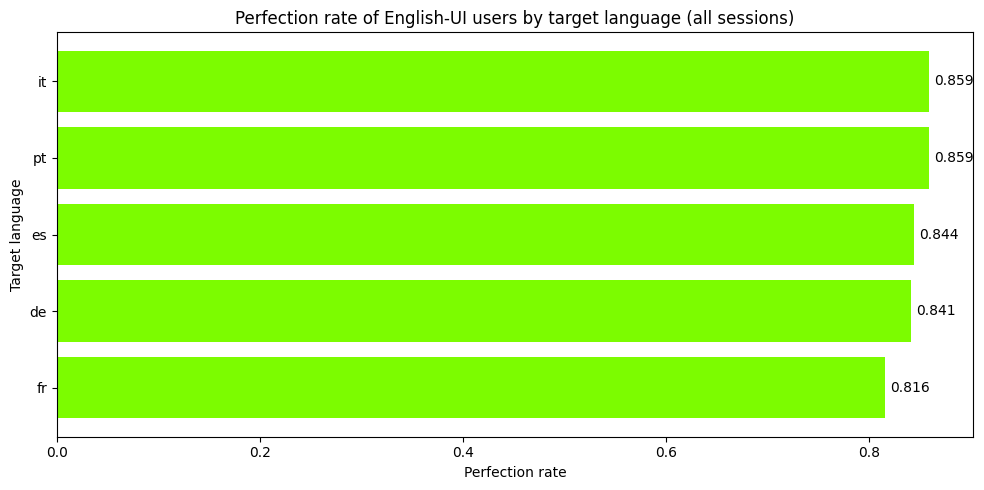

In [ ]:

plt.figure(figsize=(10, 5))
perfect_by_lang = perfect_by_lang.sort_values(ascending=True)

bars = plt.barh(
    perfect_by_lang.index,        
    perfect_by_lang.values,       
    color= "#7CFC00"
)

plt.title("Perfection rate of English-UI users by target language (all sessions)")
plt.xlabel("Perfection rate")
plt.ylabel("Target language")


for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,            
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",
        va="center",
        ha="left"
    )

plt.tight_layout()
plt.show()



The averge correct rate for english-learners of different native languages

In [ ]:

df_enlearn = df[df["learning_language"] == "en"].copy()


df_enlearn["session_perfect"] = (
    df_enlearn["session_correct"] == df_enlearn["session_seen"]
).astype(int)


global_rate = df_enlearn["session_perfect"].mean()
print("Global perfection rate for learners of English: {:.2f}%".format(100 * global_rate))


perf_by_native = (
    df_enlearn.groupby("ui_language")["session_perfect"]
              .mean()
              .sort_values(ascending=True)  
)

print(perf_by_native)

Global perfection rate for learners of English: 83.90%
ui_language
es    0.836132
pt    0.842302
it    0.856214
Name: session_perfect, dtype: float64


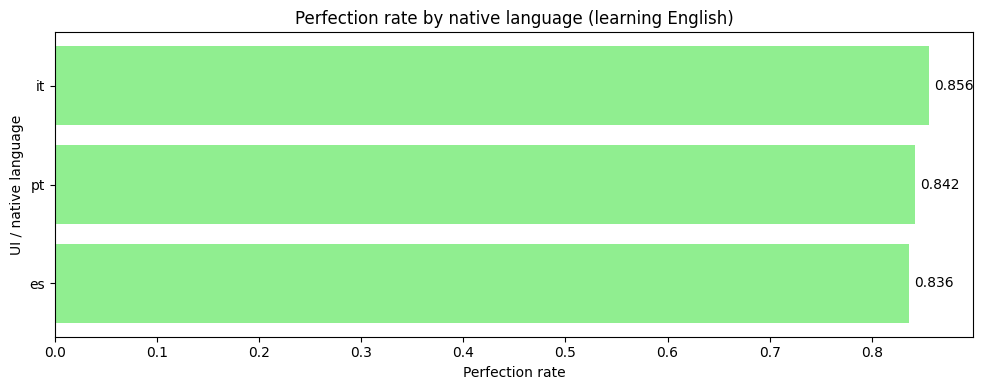

In [ ]:
plt.figure(figsize=(10, 4))

bars = plt.barh(
    perf_by_native.index,    
    perf_by_native.values,  
    color="#90EE90"      
)

plt.title("Perfection rate by native language (learning English)")
plt.xlabel("Perfection rate")
plt.ylabel("UI / native language")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.005,                           
        bar.get_y() + bar.get_height() / 2,
        f"{width:.3f}",                         
        va="center",
        ha="left"
    )

plt.tight_layout()
plt.show()


The profermance of english natives learning French

In [27]:
df_en_fr = df[(df["ui_language"] == "en") & (df["learning_language"] == "fr")].copy()

# session perfection
df_en_fr["session_perfect"] = (df_en_fr["session_correct"] == df_en_fr["session_seen"]).astype(int)

print("Rows:", len(df_en_fr))
print("Global perfection rate (en-UI, learning fr): {:.2f}%".format(100 * df_en_fr["session_perfect"].mean()))

Rows: 1873716
Global perfection rate (en-UI, learning fr): 81.59%


In [ ]:

df_en_fr["tag_list"] = df_en_fr["lexeme_string"].str.findall(r"<([^>]+)>")

tags = df_en_fr["tag_list"].explode()

tag_counts = tags.value_counts(dropna=True).rename_axis("tag").reset_index(name="count")

print("Unique tags:", tag_counts.shape[0])
tag_counts.head(50)

Unique tags: 123


,tag,count
0,sg,1166916
1,n,551665
2,m,528675
3,f,408676
4,det,367261
5,pri,356187
6,pl,299781
7,vblex,298868
8,mf,280607
9,prn,209242


In [ ]:
df_tag = (
    df_en_fr[["lexeme_string", "tag_list"]]
    .explode("tag_list")
    .rename(columns={"tag_list": "tag"})
    .dropna(subset=["tag"])
)


tag_counts = (
    df_tag["tag"]
    .value_counts()
    .rename_axis("tag")
    .reset_index(name="count")
)

print("Unique tags:", tag_counts.shape[0])

K = 5
tag_examples = (
    df_tag
    .groupby("tag")["lexeme_string"]
    .apply(lambda s: s.head(K).tolist())
    .reset_index(name="examples")
)


tag_dict = (
    tag_counts
    .merge(tag_examples, on="tag", how="left")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

tag_dict.head()

Unique tags: 123


,tag,count,examples
0,sg,1166916,"[la/le<det><def><f><sg>, mon/mon<det><pos><m><..."
1,n,551665,"[<*sf>/chemise<n><f><*numb>, <*sf>/jupe<n><f><..."
2,m,528675,"[mon/mon<det><pos><m><sg>, nouveau/nouveau<adj..."
3,f,408676,"[la/le<det><def><f><sg>, ta/ton<det><pos><f><s..."
4,det,367261,"[la/le<det><def><f><sg>, mon/mon<det><pos><m><..."


In [30]:
tag_dict.to_csv("fr_all_tags_dictionary.csv", index=False, encoding="utf-8")

In [9]:
def map_to_grammar_point(tag: str):
    # --- Agreement ---
    if tag in {"m", "f", "mf", "*gndr"}:
        return "Gender agreement"
    if tag in {"sg", "pl", "*numb"}:
        return "Number agreement"
    if tag in {"p1", "p2", "p3", "*pers"}:
        return "Person agreement"

    # --- Verb tense / mood / voice ---
    if tag == "@compound_past":
        return "Passé composé"
    if tag in {"pii"}:
        return "Imparfait"
    if tag in {"fti"}:
        return "Future"
    if tag in {"prs", "@past_subjunctive"}:
        return "Subjunctive (present / past)"
    if tag == "@passive":
        return "Passive voice"

    # --- Subordinate clauses ---
    if tag in {
        "@cnj:avant_que", "@cnj:apres_que", "@cnj:pendant_que",
        "@cnj:depuis_que", "@cnj:tandis_que", "@cnj:alors_que"
    }:
        return "Temporal subordinate clauses"

    if tag in {
        "@cnj:parce_que", "@cnj:du_fait_que", "@cnj:car"
    }:
        return "Causal subordinate clauses"

    if tag in {
        "@cnj:pour_que", "@cnj:afin_de", "@pr:afin_de"
    }:
        return "Purpose clauses"

    # --- Interrogatives ---
    if tag in {"itg", "@itg:est_ce_que", "@itg:que_est_ce_que"}:
        return "Interrogatives"

    # --- Pronouns ---
    if tag == "ref":
        return "Reflexive pronouns"
    if tag == "rel":
        return "Relative pronouns"

    # --- Formulaic ---
    if tag.startswith("@common_phrases:") or tag.startswith("@ij:") or tag.startswith("@adv:"):
        return "Formulaic expressions"

    return None


In [32]:
PRIORITY = [
    "Passé composé",
    "Imparfait",
    "Future",
    "Subjunctive (present / past)",
    "Passive voice",
    "Temporal subordinate clauses",
    "Causal subordinate clauses",
    "Purpose clauses",
    "Interrogatives",
    "Reflexive pronouns",
    "Relative pronouns",
    "Gender agreement",
    "Number agreement",
    "Person agreement",
    "Formulaic expressions",
]

priority_rank = {k: i for i, k in enumerate(PRIORITY)}

def pick_grammar_point(tag_list):
    points = [
        map_to_grammar_point(t)
        for t in tag_list
        if map_to_grammar_point(t) is not None
    ]
    if not points:
        return None
    points = sorted(points, key=lambda p: priority_rank[p])
    return points[0]


In [33]:
df_en_fr["grammar_point"] = df_en_fr["tag_list"].apply(pick_grammar_point)

plot_df = (
    df_en_fr
    .dropna(subset=["grammar_point"])
    .groupby("grammar_point")
    .agg(
        perfection_rate=("session_perfect", "mean"),
        n=("session_perfect", "size")
    )
    .reset_index()
)


In [35]:
plot_df.sort_values("perfection_rate")


,grammar_point,perfection_rate,n
2,Future,0.658416,202
8,Passé composé,0.688673,1545
7,Passive voice,0.704545,44
9,Person agreement,0.714286,504
13,Subjunctive (present / past),0.721649,97
4,Imparfait,0.739827,811
11,Reflexive pronouns,0.740569,1723
10,Purpose clauses,0.761905,63
5,Interrogatives,0.787965,24661
14,Temporal subordinate clauses,0.788000,2000


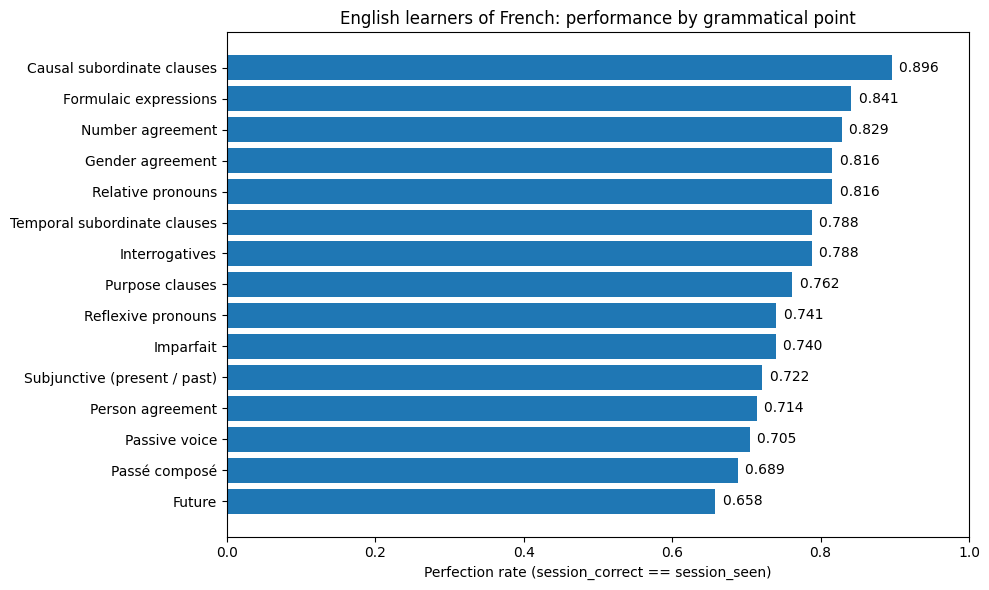

In [ ]:
plot_df = plot_df.sort_values("perfection_rate")

plt.figure(figsize=(10, 6))
bars = plt.barh(
    plot_df["grammar_point"],
    plot_df["perfection_rate"]
)

plt.xlabel("Perfection rate (session_correct == session_seen)")
plt.title("English learners of French: performance by grammatical point")
plt.xlim(0, 1)

for bar, rate, n in zip(bars, plot_df["perfection_rate"], plot_df["n"]):
    plt.text(
        rate + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{rate:.3f} ",
        va="center"
    )

plt.tight_layout()
plt.show()


In [ ]:
tag_counter = Counter()
for tags in df["tag_list"]:
    if isinstance(tags, (list, tuple)):
        tag_counter.update(tags)

tags_df = (
    pd.DataFrame(tag_counter.items(), columns=["tag", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

print("n_unique_tags:", len(tags_df))
print(tags_df.head(200)) 

n_unique_tags: 179
                      tag    count
0                      sg  7548428
1                       n  5480956
2                       m  2345375
3                      pl  2251963
4                   vblex  2235286
..                    ...      ...
174     @adv:a_posteriori        6
175         @adv:a_priori        6
176                  @pos        3
177                  @obj        1
178  @subjunctive_perfect        1

[179 rows x 2 columns]


In [27]:
tags_df.to_csv("all_tags_with_counts.csv", index=False)

Prefix-based split
-Tags starting with * are classified as META (non-linguistic or dataset-level annotations).
-Tags starting with @ are treated as grammatical constructions (CX_*).
-All other tags are interpreted as lexical or morphological features.
Construction tags (@...)
A predefined set of @ tags referring to tense, aspect, mood, voice, or modality (e.g. present perfect, passive, subjunctive) is grouped as CX_TENSE_ASPECT.
Other @ tags are classified by functional prefix:
Negation → CX_NEGATION
Interrogatives → CX_INTERROGATIVE
Multiword adverbs / prepositions / conjunctions / pronouns → CX_MW_ADV / CX_MW_PREP / CX_MW_CONJ / CX_MW_PRON
Interjections and formulaic expressions → CX_INTERJECTION / CX_COMMON_PHRASE
Register marking (e.g. @formal) → CX_REGISTER
Remaining @ tags fall into CX_OTHER.
Non-@ linguistic tags
Part of speech → POS
Person, number, gender → PERSON / NUMBER / GENDER
Case or grammatical relation → CASE_REL
Tense or mood morphology → TENSE_MOOD
Verb form → VERB_FORM
Determiner / pronoun subtype → DET_PRON_SUBTYPE
Fallback
Any tag not matching the above rules is labeled OTHER

In [ ]:


META_PREFIX = "*"
CX_PREFIX = "@"

POS = {
    "n","np","nn",
    "det","adj","adv",
    "prn","pr",
    "cnjcoo","cnjsub","cnjadv",
    "num","ij",
    "vblex","vbser","vbhaver","vbmod","vbdo","vaux"
}

PERSON = {"p1","p2","p3"}
NUMBER = {"sg","pl"}
GENDER = {"m","f","mf"}

CASE_REL = {"nom","acc","dat","gen","subj","obj","pred","attr","apos","loc","pprep","preadv"}

TENSE_MOOD = {"pri","prs","pres","past","pst","ifi","fti","pii","pis","imp","cond","cni","sint"}
VERB_FORM = {"inf","pp","ger","pprs","ant"}

DET_PRON_SUBTYPE = {
    "def","ind","dem","pos","rel","pro","pron","ref",
    "predet","qnt","ord",
    "comp","sup","mix",
    "sp","tn","nt","sw","st","an","aa",
    "acr","enc","dim","suff"
}

# @... 构式里：时态/体/语态/情态 等“语法构式名”（不带冒号的很多）
CX_TENSE_ASPECT_SET = {
    "@present_perfect","@past_perfect","@future_perfect","@cond_perfect",
    "@compound_past","@pluperfect",
    "@past","@future","@future_phrasal",
    "@past_cond","@past_inf",
    "@ger_past",
    "@subjunctive_pluperfect","@past_subjunctive","@subjunctive_perfect",
    "@passive","@modal","@cond"
}

def classify_tag(tag: str) -> str:
    if not isinstance(tag, str) or tag == "":
        return "OTHER"

    # 1) META
    if tag.startswith(META_PREFIX):
        return "META"

    # 2) CONSTRUCTIONS (@...)
    if tag.startswith(CX_PREFIX):
        if tag in CX_TENSE_ASPECT_SET:
            return "CX_TENSE_ASPECT"
        if tag.startswith("@neg:"):
            return "CX_NEGATION"
        if tag.startswith("@itg:"):
            return "CX_INTERROGATIVE"
        if tag.startswith("@adv:"):
            return "CX_MW_ADV"
        if tag.startswith("@pr:"):
            return "CX_MW_PREP"
        if tag.startswith("@cnj:"):
            return "CX_MW_CONJ"
        if tag.startswith("@prn:"):
            return "CX_MW_PRON"
        if tag.startswith("@ij:"):
            return "CX_INTERJECTION"
        if tag.startswith("@common_phrases:"):
            return "CX_COMMON_PHRASE"
        if tag == "@formal":
            return "CX_REGISTER"
        return "CX_OTHER"

    # 3) NON-@ tags
    if tag in POS:
        return "POS"
    if tag in PERSON:
        return "PERSON"
    if tag in NUMBER:
        return "NUMBER"
    if tag in GENDER:
        return "GENDER"
    if tag in CASE_REL:
        return "CASE_REL"
    if tag in TENSE_MOOD:
        return "TENSE_MOOD"
    if tag in VERB_FORM:
        return "VERB_FORM"
    if tag in DET_PRON_SUBTYPE:
        return "DET_PRON_SUBTYPE"

    return "OTHER"


#Define category space
    CATS lists all tag categories produced by classify_tag.
    cat_to_j maps each category name to a column index (for fast array access).
#Preallocate output columns
    For every category c in CATS, the code adds a new DataFrame column cat_{c} initialized to 0 (stored as uint8 to save memory).
#Chunked feature construction (memory-efficient)
    Processes the dataset in blocks of chunk_size = 1,000,000 rows to avoid building a huge matrix at once.
    For each chunk, creates an array X of shape (rows_in_chunk, n_categories) to store per-row counts.
#Count category occurrences per row
    For each row’s tag_list, it:
    classifies every tag via classify_tag(t),
    finds the corresponding category index j,
    increments X[ii, j] (capped at 255 due to uint8).
#Write results back to the DataFrame
    Copies each column of X into the matching DataFrame column cat_{c} for the current chunk.
#Cleanup
    Deletes the chunk array X and calls garbage collection to control memory usage.
    Prints "done" when all chunks are processed.

In [ ]:

CATS = [
    "META",
    "CX_TENSE_ASPECT","CX_NEGATION","CX_INTERROGATIVE","CX_MW_ADV","CX_MW_PREP","CX_MW_CONJ","CX_MW_PRON",
    "CX_INTERJECTION","CX_COMMON_PHRASE","CX_REGISTER","CX_OTHER",
    "POS","PERSON","NUMBER","GENDER","CASE_REL","TENSE_MOOD","VERB_FORM","DET_PRON_SUBTYPE",
    "OTHER"
]
cat_to_j = {c: j for j, c in enumerate(CATS)}

chunk_size = 1_000_000
n = len(df)
m = len(CATS)

for c in CATS:
    df[f"cat_{c}"] = np.zeros(n, dtype=np.uint8)

tag_lists = df["tag_list"].values

for start in range(0, n, chunk_size):
    end = min(start + chunk_size, n)
    X = np.zeros((end - start, m), dtype=np.uint8)

    for ii, tags in enumerate(tag_lists[start:end]):
        if not isinstance(tags, (list, tuple)):
            continue
        for t in tags:
            c = classify_tag(t)
            j = cat_to_j.get(c, cat_to_j["OTHER"])
            if X[ii, j] < 255:
                X[ii, j] += 1


    for j, c in enumerate(CATS):
        df.iloc[start:end, df.columns.get_loc(f"cat_{c}")] = X[:, j]

    del X
    gc.collect()

print("done")



done


In [13]:
df.head(10)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,cat_CX_OTHER,cat_POS,cat_PERSON,cat_NUMBER,cat_GENDER,cat_CASE_REL,cat_TENSE_MOOD,cat_VERB_FORM,cat_DET_PRON_SUBTYPE,cat_OTHER
0,1.00,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,...,0,1,1,1,0,0,1,0,0,0
1,0.50,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,...,0,1,0,1,1,1,0,0,1,0
2,1.00,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,...,0,1,0,1,1,1,0,0,0,0
3,0.50,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,...,0,1,0,1,1,1,0,0,0,0
4,1.00,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,...,0,1,0,1,0,1,0,0,2,0
5,1.00,1362076081,27649635,u:FO,de,en,56429751fdaedb6e491f4795c770f5a4,der/der<det><def><m><sg><nom>,4,3,...,0,1,0,1,1,1,0,0,1,0
6,1.00,1362076081,27649635,u:FO,de,en,1bacf218eaaf9f944e525f7be9b31899,kind/kind<n><nt><sg><nom>,4,4,...,0,1,0,1,0,1,0,0,1,0
7,1.00,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,...,0,1,0,0,0,0,0,0,0,0
8,1.00,1362082044,5963,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,8,6,...,0,1,1,1,0,0,1,0,0,0
9,0.75,1362082044,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,6,5,...,0,1,0,1,1,1,0,0,1,0


Log-spaced time discretization
    make_time_bins constructs logarithmically spaced time bin edges to discretize elapsed time, reflecting the fact that forgetting changes rapidly at short intervals and more slowly at long intervals.
Robust range selection
    Invalid or non-finite durations are removed.
    The upper bound max_h is set to the 99.5th percentile of observed durations (if not provided) to limit the influence of extreme long-tail gaps.
Bin edge construction
    n_bins + 1 edges are generated in log space between min_h and max_h.
    The first edge is explicitly set to 0.0 to allow zero-duration intervals.
Discrete time assignment
    assign_bin maps each duration (in hours) to a discrete time bin index using these edges.
    The resulting indices lie in 1..K, making them suitable for discrete-time hazard or survival models.

In [ ]:
def make_time_bins(hours: np.ndarray,
                   n_bins: int = 30,
                   min_h: float = 1e-6,
                   max_h: float = None) -> np.ndarray:
  """
    Create logarithmically spaced time-bin boundaries for discretizing elapsed time.

    Log-space bins are used to better match forgetting dynamics, where changes
    are rapid shortly after practice and slower at longer delays.

    Parameters
    ----------
    hours : np.ndarray
        Observed time intervals (in hours).
    n_bins : int
        Number of discrete time bins.
    min_h : float
        Minimum positive time value used to anchor the log scale.
    max_h : float or None
        Maximum time value for binning. If None, it is set to the 99.5th
        percentile of the observed data to reduce the influence of extreme
        long-tail intervals.

    Returns
    -------
    bin_edges : np.ndarray
        Array of length n_bins + 1 defining bin boundaries that cover
        the interval [0, max_h].
    """
    hours = np.asarray(hours, dtype=float)
    hours = hours[np.isfinite(hours)]
    if len(hours) == 0:
        raise ValueError("No valid durations to bin.")
    if max_h is None:
        max_h = float(np.nanpercentile(hours, 99.5))  # 避免极端长尾
        max_h = max(max_h, min_h * 10)

    # log 分桶
    edges = np.exp(np.linspace(np.log(min_h), np.log(max_h), n_bins + 1))
    edges[0] = 0.0  # 允许 0
    return edges


def assign_bin(duration_hours: np.ndarray, bin_edges: np.ndarray) -> np.ndarray:
    """
    Assign each duration value to a discrete time-bin index.

    Parameters
    ----------
    duration_hours : np.ndarray
        Elapsed time values (in hours) to be discretized.
    bin_edges : np.ndarray
        Time-bin boundaries produced by `make_time_bins`.

    Returns
    -------
    bins : np.ndarray
        Integer bin indices in the range 1..K, where K = len(bin_edges) - 1.
        These indices represent discrete time steps for downstream modeling.
    """
    d = np.asarray(duration_hours, dtype=float)
    # np.digitize 返回 1..len(edges)-1
    b = np.digitize(d, bin_edges, right=True)
    b = np.clip(b, 1, len(bin_edges) - 1)
    return b


### Episode construction for survival analysis

This function converts session-level interaction data into **episode-level survival data** suitable for discrete-time or continuous-time hazard modeling.

- **Episode start (reset)**
  - A new episode begins at a session where all items are answered correctly  
    (`session_correct == session_seen` and `session_seen ≥ min_seen`).
  - This reset session defines time `t = 0` for the episode.

- **Event definition**
  - An event occurs at the first subsequent session in which an error is made  
    (`session_correct < session_seen`).
  - When such a failure is observed, the episode ends with `event = 1`.

- **Right censoring**
  - If no failure occurs before the last observed session for a given `(user, item)` pair,
    the episode is right-censored and ends at the final timestamp (`event = 0`).

- **Duration computation**
  - Episode duration is computed as the time difference (in hours) between the reset
    session (`start_time`) and either the next failure (`end_time`) or the last observed
    session if censored.

- **Feature assignment**
  - Episode-level covariates are taken **only from the reset session** to avoid
    leakage of future information into the survival features.

- **Implementation details**
  - Data are filtered to valid rows and processed in DuckDB for efficiency.
  - Window functions are used to identify, for each reset, the next failure time
    within the same `(user, item)` sequence.
  - The output contains one row per episode with `start_time`, `end_time`,
    `duration_hours`, `event`, and optional feature columns.


In [ ]:

def build_survival_episodes_from_sessions_fast(
    df: pd.DataFrame,
    user_col: str = "user_id",
    item_col: str = "lexeme_id",
    time_col: str = "timestamp",
    seen_col: str = "session_seen",
    correct_col: str = "session_correct",
    feature_cols: list[str] | None = None,
    min_seen: int = 1,
) -> pd.DataFrame:
    """
    Construct episode-level survival data from session-level interactions.

    Definitions
    ----------
    - Reset: a "fully correct" session (session_correct == session_seen) with session_seen >= min_seen.
      Each reset starts a new episode (t = 0).
    - Event: the first subsequent session with an error (session_correct < session_seen) with session_seen >= min_seen.
      If such a failure occurs, the episode ends at that time with event=1.
    - Censoring: if no failure is observed before the last available session for the (user, item) sequence,
      the episode ends at the last observed timestamp with event=0.

    Feature handling
    ---------------
    Episode covariates are taken from the reset row only (i.e., at episode start) to avoid leakage of future
    information into the episode features.

    Returns
    -------
    episodes : pd.DataFrame
        One row per episode, containing:
        - start_time, end_time
        - duration_hours (time-to-event or time-to-censoring)
        - event (1 = failure observed, 0 = right-censored)
        - optional feature columns copied from the reset row
    """
    # If feature_cols is not provided, treat all non-key columns as features.
    if feature_cols is None:
        base = {user_col, item_col, time_col, seen_col, correct_col}
        feature_cols = [c for c in df.columns if c not in base]

    # Keep only required columns to reduce memory footprint when passing data to DuckDB.
    use_cols = [user_col, item_col, time_col, seen_col, correct_col] + feature_cols
    use_cols = [user_col, item_col, time_col, seen_col, correct_col] + feature_cols
    d = df.loc[:, use_cols]

    
    if not pd.api.types.is_datetime64_any_dtype(d[time_col]):
        d = d.copy()
        d[time_col] = pd.to_datetime(d[time_col], errors="coerce")

    con = duckdb.connect()
    con.register("d", d)

    # SQL outline:
    # 1) Filter to valid rows and rename columns to stable SQL aliases.
    # 2) Flag reset rows (all-correct) and event rows (any error).
    # 3) For each (user, item), compute:
    #    - last_time: last observed timestamp
    #    - next_event_time: first event timestamp strictly after the current row
    # 4) Keep only reset rows as episode starts; end at next_event_time if it exists, else last_time.
    sql = f"""
    WITH base AS (
      SELECT
        {user_col} AS user_id,
        {item_col} AS item_id,
        {time_col} AS ts,
        {seen_col} AS seen,
        {correct_col} AS corr,
        {", ".join(feature_cols) if feature_cols else ""}
      FROM d
      WHERE ts IS NOT NULL
        AND user_id IS NOT NULL
        AND item_id IS NOT NULL
        AND seen IS NOT NULL
        AND corr IS NOT NULL
        AND seen >= {int(min_seen)}
    ),
    flagged AS (
      SELECT
        *,
        (corr = seen) AS is_reset,
        (corr < seen) AS is_event
      FROM base
    ),
    with_windows AS (
      SELECT
        *,
        MAX(ts) OVER (PARTITION BY user_id, item_id) AS last_time,
        MIN(CASE WHEN is_event THEN ts END) OVER (
          PARTITION BY user_id, item_id
          ORDER BY ts
          ROWS BETWEEN 1 FOLLOWING AND UNBOUNDED FOLLOWING
        ) AS next_event_time
      FROM flagged
    )
    SELECT
      user_id AS {user_col},
      item_id AS {item_col},
      ts AS start_time,
      COALESCE(next_event_time, last_time) AS end_time,
      CASE WHEN next_event_time IS NULL THEN 0 ELSE 1 END AS event,
      GREATEST(
        0.0,
        EXTRACT(EPOCH FROM (COALESCE(next_event_time, last_time) - ts))/3600.0
      ) AS duration_hours
      {("," + ", ".join(feature_cols)) if feature_cols else ""}
    FROM with_windows
    WHERE is_reset
    """

    ep = con.execute(sql).df()
    con.close()
    return ep


### Expansion to person–period (discrete-time hazard) format

This function converts episode-level survival data into a **person–period representation** suitable for discrete-time hazard modeling.

- **Time discretization**
  - Each episode’s continuous duration is mapped to a discrete time bin using predefined `bin_edges`.

- **Row expansion**
  - An episode with time bin `K` is expanded into `K` rows, corresponding to time steps `1, …, K`.

- **Outcome assignment**
  - For the first `K−1` rows, the hazard label is set to `0` (no event yet).
  - At time step `K`, the hazard label equals the episode’s event indicator:
    - `1` if a failure occurs at that time,
    - `0` if the episode is right-censored.

- **Feature handling**
  - All covariates are copied unchanged from the episode-level features,
    ensuring that each time step shares the same baseline information.

- **Output**
  - The result is a long-format DataFrame with one row per episode–time-bin pair,
    containing features, `time_bin`, and the discrete-time hazard label `y_hazard`.

In [ ]:

def expand_to_person_period(
    episodes: pd.DataFrame,
    bin_edges: np.ndarray,
    feature_cols: list[str],
    duration_col: str = "duration_hours",
    event_col: str = "event",
) -> pd.DataFrame:
    """
    Expand each episode (duration, event) into multiple rows in discrete time:
    - Rows correspond to time_bin = 1..K
    - The hazard label is 0 for all bins before K
    - At bin K, the label equals the event indicator (0 if censored)
    """
    ep = episodes.copy()
    ep["time_bin"] = assign_bin(ep[duration_col].values, bin_edges)

    rows = []
    for i, r in ep.iterrows():
        K = int(r["time_bin"])
        ev = int(r[event_col])

        base = {c: r[c] for c in feature_cols}
        for tb in range(1, K + 1):
            rr = dict(base)
            rr["time_bin"] = tb
            rr["y_hazard"] = 1 if (ev == 1 and tb == K) else 0
            rows.append(rr)

    out = pd.DataFrame(rows)
    return out

### Discrete-time hazard model training (CatBoost)

- **Goal**
  - Train a classifier that estimates the discrete hazard:
    \[
    P(\text{event at time bin } t \mid \text{survived to } t-1,\; x)
    \]
  - The target label is `y_hazard` in the person–period table.

- **Training procedure**
  - Use all columns except `y_hazard` as features (including `time_bin`).
  - Build CatBoost `Pool`s for train/validation (optionally specifying categorical features).
  - Fit a `CatBoostClassifier` with log-loss, fixed iteration count, and subsampling.

### Predicting a forgetting curve from the hazard model

- **Input**
  - Static episode features `x_static` (no `time_bin`).
- **Process**
  - Create one row per `time_bin = 1..T`, append `time_bin` to the static features, and predict hazard probabilities.
- **Outputs**
  - `hazard[t]`: predicted event probability at each bin.
  - `survival[t] = ∏(1 - hazard[t])`: probability of still being correct up to bin `t`.
  - `F(t) = 1 - survival[t]`: cumulative failure/forgetting probability.

In [ ]:
def fit_hazard_catboost(
    pp_train: pd.DataFrame,
    pp_valid: pd.DataFrame,
    cat_features: list[str] = None,
    iterations: int = 2000,
    lr: float = 0.1,
    depth: int = 8,
    subsample: float = 0.7,
    random_seed: int = 42,
):
    """
    Train a discrete-time hazard classifier on person–period data.

    The model learns:
        P(event at time bin t | survived to t-1, x)
    where the binary target is `y_hazard`.
    """
    feature_cols = [c for c in pp_train.columns if c != "y_hazard"]
    Xtr, ytr = pp_train[feature_cols], pp_train["y_hazard"].astype(int)
    Xva, yva = pp_valid[feature_cols], pp_valid["y_hazard"].astype(int)

    if cat_features is None:
        cat_features = []

    
    train_pool = Pool(Xtr, ytr, cat_features=cat_features)
    valid_pool = Pool(Xva, yva, cat_features=cat_features)

    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",
        iterations=iterations,
        learning_rate=lr,
        depth=depth,
        bootstrap_type="Bernoulli",
        subsample=subsample,
        random_seed=random_seed,
        task_type="CPU",
        thread_count=-1,
        verbose=100,
        metric_period=20,     
    )

    model.fit(train_pool, eval_set=valid_pool, use_best_model=False)
    return model, feature_cols


def predict_forgetting_curve(model: CatBoostClassifier,
                            x_static: dict,
                            feature_cols: list[str],
                            bin_edges: np.ndarray,
                            max_bin: int = None):
    """
    Predict a forgetting curve from a trained discrete-time hazard model.

    Given static episode features x_static (excluding time_bin), this function produces:
    - hazard[t]:   P(event at bin t | survived to t-1, x)
    - survival[t]: S(t) = Π_{i=1..t} (1 - hazard[i])
    - F(t):        cumulative failure probability = 1 - S(t)
    """
    if max_bin is None:
        max_bin = len(bin_edges) - 1

    rows = []
    for tb in range(1, max_bin + 1):
        r = dict(x_static)
        r["time_bin"] = tb
        rows.append(r)

    X = pd.DataFrame(rows)[feature_cols]
    h = model.predict_proba(X)[:, 1]  # hazard prob

    S = np.cumprod(1.0 - h)
    F = 1.0 - S
    return h, S, F


### Bucketed episode construction and sampled person–period data

- **Speed up Parquet reads**
  - Wrap `pd.read_parquet` so it defaults to `engine="fastparquet"` unless an engine is explicitly provided.

### Build episodes in buckets (disk-backed)

- **Goal**
  - Construct survival episodes per `(user, item)` and **write results into many small Parquet files** to avoid holding everything in RAM.

- **Preprocessing**
  - Keep only required columns; ensure timestamps are `datetime`.
  - Filter invalid rows and enforce `seen >= min_seen`.
  - Create reset/event flags:
    - reset: `correct == seen`
    - event:  `correct < seen`

- **Bucketing**
  - Compute a stable hash of `(user, item)` and assign each pair to one of `n_buckets`.
  - Sort once by `bucket, user, item, time` so per-bucket processing is sequential and cheap.

- **Episode extraction per group**
  - For each `(user, item)` sequence:
    - Each reset starts an episode at `start_time`.
    - Episode ends at the **next event time** if it exists; otherwise at the last timestamp (censoring).
    - Compute `duration_hours` and `event` indicator.
    - Copy features from the reset row only (no future leakage).
  - Write one Parquet file per bucket: `episodes_bucket=XXXX.parquet`.

### Estimate time split and bin edges from episode files

- **Goal**
  - Avoid loading all episodes to pick:
    - a **time-based split cut** (`cut` = quantile of `start_time`)
    - **log-spaced time bins** (`bin_edges` from sampled `duration_hours`)
- **Method**
  - Sample up to `sample_per_file` rows from each bucket file, aggregate samples, then compute `cut` and `bin_edges`.

### Sampled person–period expansion (negative sampling)

- **Goal**
  - Build a smaller discrete-time hazard dataset without expanding every episode into all time bins.
- **Method**
  - For event episodes: add **1 positive** row at `time_bin = t_end`.
  - For all episodes: add `n_neg` **negative** rows by sampling `time_bin` uniformly from `1..t_end`
    (and avoiding `t_end` for event episodes).
- **Output**
  - Long-format table with features + `time_bin` + binary label `y_hazard`.


In [ ]:
if not getattr(pd.read_parquet, "_is_fastparquet_wrapper", False):
    _orig_read_parquet = pd.read_parquet

    def read_parquet_fast(*args, **kwargs):
        # 如果用户已经显式指定 engine，就不覆盖
        kwargs.setdefault("engine", "fastparquet")
        return _orig_read_parquet(*args, **kwargs)

    read_parquet_fast._is_fastparquet_wrapper = True
    pd.read_parquet = read_parquet_fast

def build_survival_episodes_bucketed(
    df: pd.DataFrame,
    out_dir: str,
    n_buckets: int = 4096,
    user_col: str = "user_id",
    item_col: str = "lexeme_id",
    time_col: str = "timestamp",
    seen_col: str = "session_seen",
    correct_col: str = "session_correct",
    feature_cols: list[str] | None = None,
    min_seen: int = 1,
):
    """Same episode definition as build_survival_episodes_from_sessions, but writes per-bucket parquet files."""
    os.makedirs(out_dir, exist_ok=True)

    base_cols = [user_col, item_col, time_col, seen_col, correct_col]
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in set(base_cols)]
    use_cols = base_cols + feature_cols
    d = df.loc[:, use_cols]

    # time to datetime
    if not pd.api.types.is_datetime64_any_dtype(d[time_col]):
        d = d.copy()
        d[time_col] = pd.to_datetime(d[time_col], errors="coerce")

    # filter
    d = d.dropna(subset=[time_col, user_col, item_col, seen_col, correct_col])
    d = d[d[seen_col] >= min_seen]

    # flags
    d = d.copy()
    d["_is_reset"] = (d[correct_col].to_numpy() == d[seen_col].to_numpy()).astype(np.uint8)
    d["_is_event"] = (d[correct_col].to_numpy() <  d[seen_col].to_numpy()).astype(np.uint8)

    # stable bucket by (user,item)
    pair_hash = pd.util.hash_pandas_object(d[[user_col, item_col]], index=False).to_numpy()
    d["_bucket"] = (pair_hash % np.uint64(n_buckets)).astype(np.int16)

    # one-pass sort to avoid per-bucket full scans
    d = d.sort_values(["_bucket", user_col, item_col, time_col], kind="mergesort")

    def _build_one_group(g: pd.DataFrame) -> pd.DataFrame | None:
        reset_pos = np.flatnonzero(g["_is_reset"].to_numpy())
        if reset_pos.size == 0:
            return None

        ts = g[time_col].to_numpy()
        event_pos = np.flatnonzero(g["_is_event"].to_numpy())

        if event_pos.size == 0:
            start_time = ts[reset_pos]
            end_time = np.repeat(ts[-1], reset_pos.size)
            event = np.zeros(reset_pos.size, dtype=np.int8)
        else:
            idx = np.searchsorted(event_pos, reset_pos, side="right")
            has_event = idx < event_pos.size
            next_event_pos = np.empty_like(reset_pos)
            next_event_pos[has_event] = event_pos[idx[has_event]]

            start_time = ts[reset_pos]
            # 先默认全部删失到最后时刻
            end_time = np.repeat(ts[-1], reset_pos.size)
            # 只对有 event 的 reset，写入对应的 event 时刻
            end_time[has_event] = ts[next_event_pos[has_event]]
            event = has_event.astype(np.int8)
       
        duration_hours = (end_time - start_time) / np.timedelta64(1, "h")
        duration_hours = np.maximum(duration_hours.astype(np.float32), 0.0)

        feat_df = g.iloc[reset_pos][feature_cols].reset_index(drop=True) if feature_cols else None
        out = pd.DataFrame({
            user_col: g[user_col].iloc[0],
            item_col: g[item_col].iloc[0],
            "start_time": start_time,
            "end_time": end_time,
            "duration_hours": duration_hours,
            "event": event,
        })
        if feat_df is not None:
            out = pd.concat([out, feat_df], axis=1)
        return out

    # write each bucket
    for b, part in d.groupby("_bucket", sort=False):
        ep_parts = []
        for _, g in part.groupby([user_col, item_col], sort=False):
            ep_g = _build_one_group(g)
            if ep_g is not None and not ep_g.empty:
                ep_parts.append(ep_g)

        if ep_parts:
            episodes_b = pd.concat(ep_parts, ignore_index=True)
            episodes_b.to_parquet(os.path.join(out_dir, f"episodes_bucket={int(b):04d}.parquet"), index=False, engine="fastparquet")

        del part, ep_parts
        gc.collect()

    return out_dir


def estimate_cut_and_bins_from_episode_files(
    episode_dir: str,
    cut_q: float = 0.8,
    n_bins: int = 30,
    sample_per_file: int = 20000,
    random_seed: int = 42,
):
    """Estimate time split cut and bin edges by sampling start_time and duration_hours from bucket files."""
    rng = np.random.default_rng(random_seed)
    files = sorted(glob.glob(os.path.join(episode_dir, "episodes_bucket=*.parquet")))
    starts, durs = [], []
    for fp in files:
        ep = pd.read_parquet(fp, columns=["start_time", "duration_hours"], engine="fastparquet")
        if len(ep) == 0:
            continue
        k = min(sample_per_file, len(ep))
        idx = rng.choice(len(ep), size=k, replace=False)
        starts.append(ep["start_time"].iloc[idx])
        durs.append(ep["duration_hours"].iloc[idx])
    s_start = pd.concat(starts, ignore_index=True)
    s_dur = pd.concat(durs, ignore_index=True)
    cut = s_start.quantile(cut_q)
    bin_edges = make_time_bins(s_dur.to_numpy(), n_bins=n_bins)
    return cut, bin_edges


def expand_to_person_period_sampled(
    episodes: pd.DataFrame,
    bin_edges: np.ndarray,
    feature_cols: list[str],
    n_neg: int = 3,
    random_seed: int = 42,
) -> pd.DataFrame:
    """Sampled discrete-time hazard dataset: 1 positive (if event) + n_neg negatives per episode."""
    rng = np.random.default_rng(random_seed)
    max_bin = len(bin_edges) - 1
    t_end = np.digitize(episodes["duration_hours"].to_numpy(), bin_edges, right=True)
    t_end = np.clip(t_end, 1, max_bin)
    ev = episodes["event"].to_numpy().astype(np.int8)

    rows = []

    # positives
    pos_idx = np.flatnonzero(ev == 1)
    if pos_idx.size > 0:
        pos = episodes.iloc[pos_idx][feature_cols].copy()
        pos["time_bin"] = t_end[pos_idx]
        pos["y_hazard"] = 1
        rows.append(pos)

    # negatives (for all episodes)
    n = len(episodes)
    if n_neg > 0 and n > 0:
        base = episodes[feature_cols].copy()
        rep = pd.concat([base] * n_neg, ignore_index=True)

        tb_list = []
        for _ in range(n_neg):
            u = rng.random(n)
            draw = 1 + np.floor(u * t_end).astype(int)  # 1..t_end
            # avoid conflict for event episodes: don't draw t_end as negative
            mask = (ev == 1) & (draw == t_end)
            draw[mask] = np.maximum(1, draw[mask] - 1)
            tb_list.append(draw)
        rep["time_bin"] = np.concatenate(tb_list, axis=0)
        rep["y_hazard"] = 0
        rows.append(rep)

    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=feature_cols + ["time_bin", "y_hazard"])
    return out


### End-to-end pipeline: episodes → sampled person–period → hazard model → review time

- **(A) Feature specification**
  - Define a fixed list of episode-level features (`FEATURE_COLS`), including history/temporal variables, a language-pair categorical feature, and grammar-tag count features (`cat_*`).
  - Declare categorical columns for CatBoost (`CAT_FEATURE_NAMES = ["lang_pair"]`).

- **(B) Episode construction (disk-backed)**
  - Build survival episodes for each `(user, lexeme)` and write them to bucketed Parquet files in `EPISODE_DIR` to avoid loading all episodes into memory.

- **(C–D) Time split + binning (estimated by sampling)**
  - Estimate a chronological split point `cut` (80th percentile of `start_time`) and log-spaced `bin_edges` from sampled episode durations.

- **(E) Sampled person–period dataset with size budgets**
  - Iterate over episode bucket files:
    - split episodes into train/valid by `start_time <= cut`,
    - expand each episode into a **sampled** discrete-time hazard dataset (1 positive + `N_NEG` negatives),
    - stop once reaching row-count budgets (`MAX_PP_TRAIN`, `MAX_PP_VALID`).
  - Concatenate chunks into `pp_train` and `pp_valid`.

- **(F) Train hazard classifier**
  - Fit a CatBoost binary classifier to predict `y_hazard` using the person–period features (including `time_bin`).

- **(G) Produce a forgetting curve**
  - Take one validation episode’s static features and predict:
    - hazard over time bins,
    - survival `S(t)`,
    - cumulative forgetting probability `F(t)`.

- **(H) Convert a forgetting threshold into a review time**
  - Choose a target threshold `alpha` (e.g., 0.2) and return the earliest time bin where `F(t) ≥ alpha`,
    then map that bin to hours via `bin_edges`.


In [ ]:

# ---- (A) Explicitly define the feature set used for episode construction and hazard modeling ----
# Keeping this list explicit is safer than implicit selection (prevents accidental leakage or missing columns).
FEATURE_COLS = [
    "delta_hours", "log_delta_hours",
    "history_seen", "history_correct", "hist_acc",
    "hour", "dow", "n_skill",
    "lang_pair",
    # 语法点 one-hot / count 特征
    "cat_META", "cat_CX_TENSE_ASPECT", "cat_CX_NEGATION", "cat_CX_INTERROGATIVE",
    "cat_CX_MW_ADV", "cat_CX_MW_PREP", "cat_CX_MW_CONJ", "cat_CX_MW_PRON",
    "cat_CX_INTERJECTION", "cat_CX_COMMON_PHRASE", "cat_CX_REGISTER", "cat_CX_OTHER",
    "cat_POS", "cat_PERSON", "cat_NUMBER", "cat_GENDER", "cat_CASE_REL",
    "cat_TENSE_MOOD", "cat_VERB_FORM", "cat_DET_PRON_SUBTYPE", "cat_OTHER",
]

CAT_FEATURE_NAMES = ["lang_pair"]

# ---- (B) Build survival episodes and write them to bucketed Parquet files (memory-safe) ----
EPISODE_DIR = "./episodes_parquet"
_ = build_survival_episodes_bucketed(
    df,
    out_dir=EPISODE_DIR,
    n_buckets=4096,         
    user_col="user_id",
    item_col="lexeme_id",
    time_col="timestamp",
    seen_col="session_seen",
    correct_col="session_correct",
    feature_cols=FEATURE_COLS,
    min_seen=1
)

# ---- (C)+(D) Estimate chronological split point and discretization bins via sampling ----
# cut: time-based split threshold (e.g., 80% quantile of episode start times)
# bin_edges: log-spaced duration bins estimated from sampled episode durations
cut, bin_edges = estimate_cut_and_bins_from_episode_files(
    EPISODE_DIR, cut_q=0.8, n_bins=30, sample_per_file=20000, random_seed=42
)
print("estimated cut:", cut, "n_bins:", len(bin_edges)-1)

# ---- (E) Build sampled person–period datasets by reading episodes bucket-by-bucket ----
# Use negative sampling to reduce data size: per episode, sample N_NEG negative time bins (+ 1 positive if event).
import glob
ep_files = sorted(glob.glob(os.path.join(EPISODE_DIR, "episodes_bucket=*.parquet")))

N_NEG = 3  # 每个 episode 抽 3 个负样本（pp 行数约 ~= episodes*(N_NEG) + positives）
MAX_PP_TRAIN = 2_000_000
MAX_PP_VALID =   300_000

pp_train_chunks, pp_valid_chunks = [], []
n_tr = 0
n_va = 0

for fp in ep_files:
    ep = pd.read_parquet(fp, engine="fastparquet")  # 单桶，不会太大
    if len(ep) == 0:
        continue

    ep_train = ep[ep["start_time"] <= cut]
    ep_valid = ep[ep["start_time"] >  cut]

    if n_tr < MAX_PP_TRAIN and len(ep_train) > 0:
        pp_tr = expand_to_person_period_sampled(ep_train, bin_edges, FEATURE_COLS, n_neg=N_NEG, random_seed=42)
        pp_train_chunks.append(pp_tr)
        n_tr += len(pp_tr)

    if n_va < MAX_PP_VALID and len(ep_valid) > 0:
        pp_va = expand_to_person_period_sampled(ep_valid, bin_edges, FEATURE_COLS, n_neg=N_NEG, random_seed=43)
        pp_valid_chunks.append(pp_va)
        n_va += len(pp_va)

    if n_tr >= MAX_PP_TRAIN and n_va >= MAX_PP_VALID:
        break

    del ep, ep_train, ep_valid
    gc.collect()

pp_train = pd.concat(pp_train_chunks, ignore_index=True)
pp_valid = pd.concat(pp_valid_chunks, ignore_index=True)

print("pp_train shape:", pp_train.shape, "pp_valid shape:", pp_valid.shape)

# ---- (F) Train the discrete-time hazard classifier ----
# The model predicts y_hazard (event-at-bin) using episode features + time_bin.
hazard_model, pp_feature_cols = fit_hazard_catboost(
    pp_train, pp_valid,
    cat_features=CAT_FEATURE_NAMES,
    iterations=2000,
    lr=0.1,
    depth=8,
    subsample=0.7,
    random_seed=42,
)

# ---- (G) Generate an example forgetting curve from the fitted model ----
# Select one validation episode as a demo input (static features only).
ep0 = None
for fp in ep_files:
    ep = pd.read_parquet(fp, columns=["start_time","event","duration_hours"] + FEATURE_COLS)
    epv = ep[ep["start_time"] > cut]
    if len(epv) > 0:
        ep0 = epv.iloc[0]
        break
if ep0 is None:
    raise RuntimeError("No validation episode found. Try lowering cut_q or check data.")

x0 = ep0[FEATURE_COLS].to_dict()
h, S, F = predict_forgetting_curve(hazard_model, x0, pp_feature_cols, bin_edges)
print("Example: F(t) at last bin =", float(F[-1]))

# ---- (H) Convert a forgetting threshold into a suggested review time ----
# Find the earliest time bin where cumulative forgetting reaches alpha, then map to hours.
alpha = 0.2
t_bin = int(np.argmax(F >= alpha) + 1)
suggest_hours = float(bin_edges[t_bin])
print("Suggested review time (hours) for alpha=0.2:", suggest_hours)


estimated cut: 2013-03-10 04:59:00 n_bins: 30
pp_train shape: (2004353, 32) pp_valid shape: (300953, 32)
0:	learn: 0.4587256	test: 0.4351381	best: 0.4351381 (0)	total: 428ms	remaining: 14m 15s
100:	learn: 0.1046502	test: 0.0702891	best: 0.0702707 (40)	total: 28.1s	remaining: 8m 47s
200:	learn: 0.1033418	test: 0.0705011	best: 0.0702707 (40)	total: 54.8s	remaining: 8m 10s
300:	learn: 0.1023167	test: 0.0706560	best: 0.0702707 (40)	total: 1m 21s	remaining: 7m 41s
400:	learn: 0.1015204	test: 0.0708072	best: 0.0702707 (40)	total: 1m 48s	remaining: 7m 12s
500:	learn: 0.1007825	test: 0.0709264	best: 0.0702707 (40)	total: 2m 14s	remaining: 6m 43s
600:	learn: 0.1000705	test: 0.0710356	best: 0.0702707 (40)	total: 2m 41s	remaining: 6m 15s
700:	learn: 0.0994122	test: 0.0711266	best: 0.0702707 (40)	total: 3m 8s	remaining: 5m 48s
800:	learn: 0.0988132	test: 0.0712473	best: 0.0702707 (40)	total: 3m 34s	remaining: 5m 21s
900:	learn: 0.0982310	test: 0.0713490	best: 0.0702707 (40)	total: 4m 1s	remaining:

In [55]:
reset_rate = (df["session_correct"] == df["session_seen"]).mean()
n_reset = (df["session_correct"] == df["session_seen"]).sum()
print("reset_rate =", reset_rate, "n_reset =", n_reset)

reset_rate = 0.8388648175355109 n_reset = 10782890


In [ ]:
def get_F_curve(model, x_static, feature_cols, bin_edges):
    h, S, F = predict_forgetting_curve(
        model, x_static, feature_cols, bin_edges
    )
    # 用 bin 上界当作时间（也可以换成中点）
    t_hours = bin_edges[1:len(F)+1]
    return t_hours, F


Chosen user_id=u:iSkh, distinct items used for plot=2


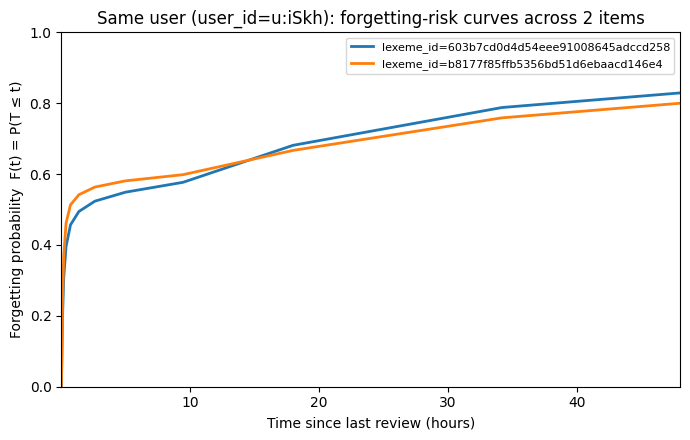

In [ ]:
ITEM_COL = "lexeme_id"   
MIN_ITEMS = 2         
N_PLOT = 8               

assert "user_id" in ep_valid.columns, "ep_valid must contain user_id"
assert ITEM_COL in ep_valid.columns, f"ep_valid must contain {ITEM_COL}"

# =========================================================
# 1) 自动选一个“多 item 用户”（按 distinct item 计数）
# =========================================================
user_item_counts = (
    ep_valid.drop_duplicates(subset=["user_id", ITEM_COL])
           .groupby("user_id")
           .size()
)

eligible_users = user_item_counts[user_item_counts >= MIN_ITEMS].index
if len(eligible_users) == 0:
    raise ValueError(f"No user has >= {MIN_ITEMS} distinct items in ep_valid for ITEM_COL={ITEM_COL}.")

# 选 item 最多的那个用户（展示最稳定）
u = user_item_counts.loc[eligible_users].idxmax()

# 取该用户的 N_PLOT 个不同 item 的 episode（每个 item 取第一个 episode）
eps_u = (
    ep_valid[ep_valid["user_id"] == u]
    .drop_duplicates(subset=[ITEM_COL])
    .head(N_PLOT)
)

print(f"Chosen user_id={u}, distinct items used for plot={len(eps_u)}")

# =========================================================
# 2) 画：同一 user，多 item 的 F(t) 曲线
# =========================================================
plt.figure(figsize=(7, 4.5))

curves = []
for j, (_, row) in enumerate(eps_u.iterrows()):
    x_static = row[FEATURE_COLS].to_dict()
    t, F = get_F_curve(hazard_model, x_static, pp_feature_cols, bin_edges)
    curves.append((t, F))

    item_val = row[ITEM_COL]
    plt.plot(t, F, lw=2, label=f"{ITEM_COL}={item_val}")

plt.xlabel("Time since last review (hours)")
plt.ylabel("Forgetting probability  F(t) = P(T ≤ t)")
plt.title(f"Same user (user_id={u}): forgetting-risk curves across {len(eps_u)} items")
plt.xlim(1e-2, 48)
plt.ylim(0, 1)
plt.legend(fontsize=8, ncol=1, frameon=True)
plt.tight_layout()
plt.show()




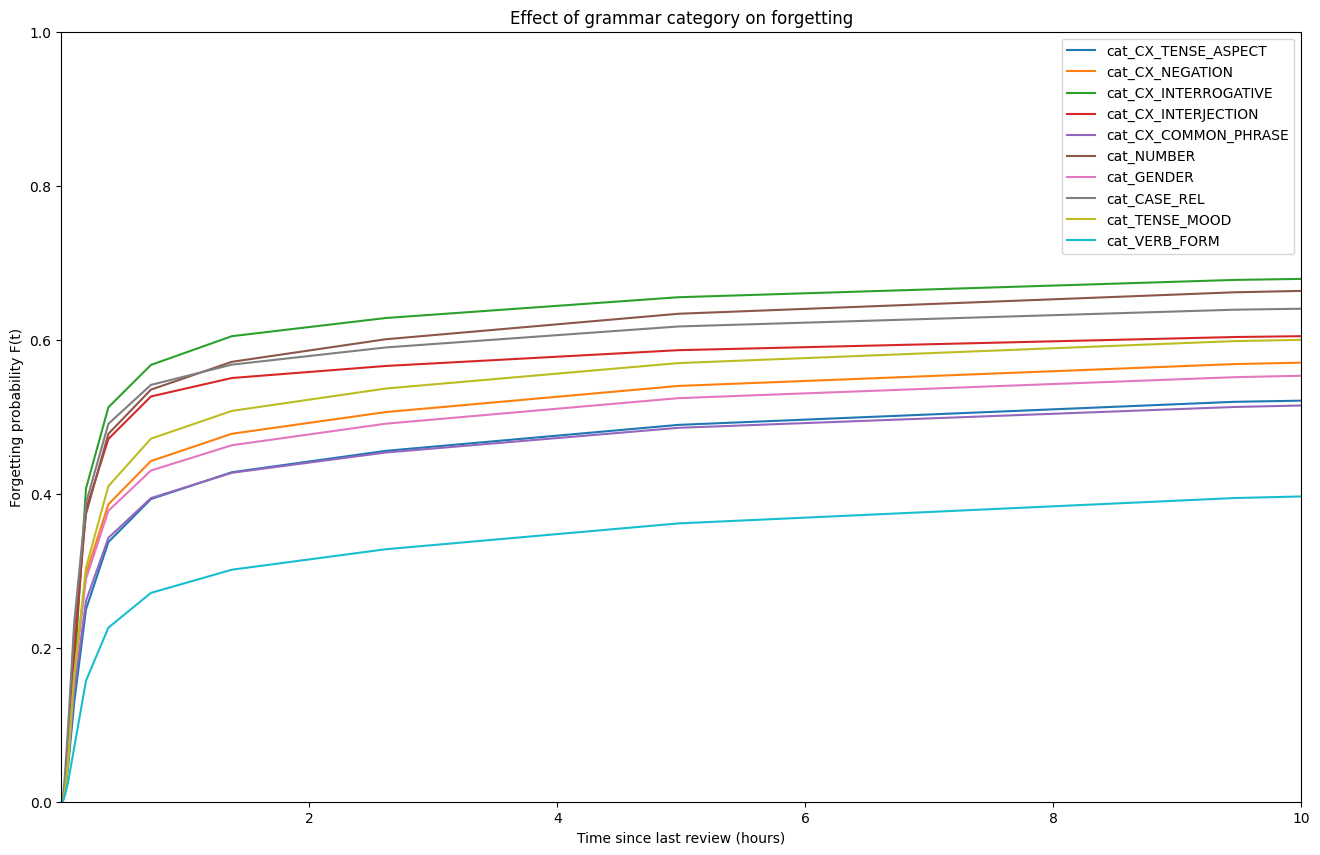

<Figure size 640x480 with 0 Axes>

In [ ]:
# 选一个 reference episode
row0 = ep_valid.iloc[0]
x_base = row0[FEATURE_COLS].to_dict()

# 想对比的语法点
cats = [
    "cat_CX_TENSE_ASPECT",
    "cat_CX_NEGATION",
    "cat_CX_INTERROGATIVE",
    
    "cat_CX_INTERJECTION", 
    "cat_CX_COMMON_PHRASE", 
    "cat_NUMBER", 
    "cat_GENDER", "cat_CASE_REL",
    "cat_TENSE_MOOD",
    "cat_VERB_FORM"
]

plt.figure(figsize=(16,10))

for cat in cats:
    x = dict(x_base)
    # 只激活一个 cat（假设 one-hot / count ≥1）
    for c in cats:
        x[c] = 0
    x[cat] = 1

    t, F = get_F_curve(hazard_model, x, pp_feature_cols, bin_edges)
    plt.plot(t, F, label=cat)

plt.xlabel("Time since last review (hours)")
plt.ylabel("Forgetting probability F(t)")
plt.title("Effect of grammar category on forgetting")
plt.legend()

plt.xlim(0.001, 10) 
plt.ylim(0, 1)
plt.show()
plt.savefig("grammar_curves.pdf", bbox_inches="tight")

In [42]:
import pandas as pd

print(df["timestamp"].dtype)
print(df["timestamp"].head(3))

ts = pd.to_datetime(df["timestamp"], errors="coerce")
print("parsed dtype:", ts.dtype)
print("min:", ts.min(), "max:", ts.max())
print("na rate:", ts.isna().mean())


datetime64[ns]
0   2013-02-28 18:28:01
1   2013-02-28 18:28:01
2   2013-02-28 18:28:01
Name: timestamp, dtype: datetime64[ns]
parsed dtype: datetime64[ns]
min: 2013-02-28 18:28:01 max: 2013-03-12 16:14:57
na rate: 0.0


In [44]:
df.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,cat_VERB_FORM,cat_DET_PRON_SUBTYPE,cat_OTHER,y,lang_pair,hour,dow,log_delta_hours,hist_acc,sess_acc
0,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,...,0,0,0,1.0,en->de,18,3,8.946564,0.625000,0.750000
1,0.5,2013-02-28 18:28:01,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,...,0,1,0,0.5,en->de,18,3,8.946564,0.833333,0.500000
2,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,...,0,0,0,1.0,en->de,18,3,8.946564,0.714286,0.666667
3,0.5,2013-02-28 18:28:01,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,...,0,0,0,0.5,en->de,18,3,8.946564,0.750000,0.500000
4,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,...,0,2,0,1.0,en->de,18,3,8.946564,0.833333,0.666667


In [48]:
print(df["lang_pair"].dropna().astype(str).value_counts().head(20))


lang_pair
es->en    3641167
en->es    3407654
en->fr    1873716
en->de    1452597
pt->en     949460
en->it     793919
it->en     424152
en->pt     311480
Name: count, dtype: int64


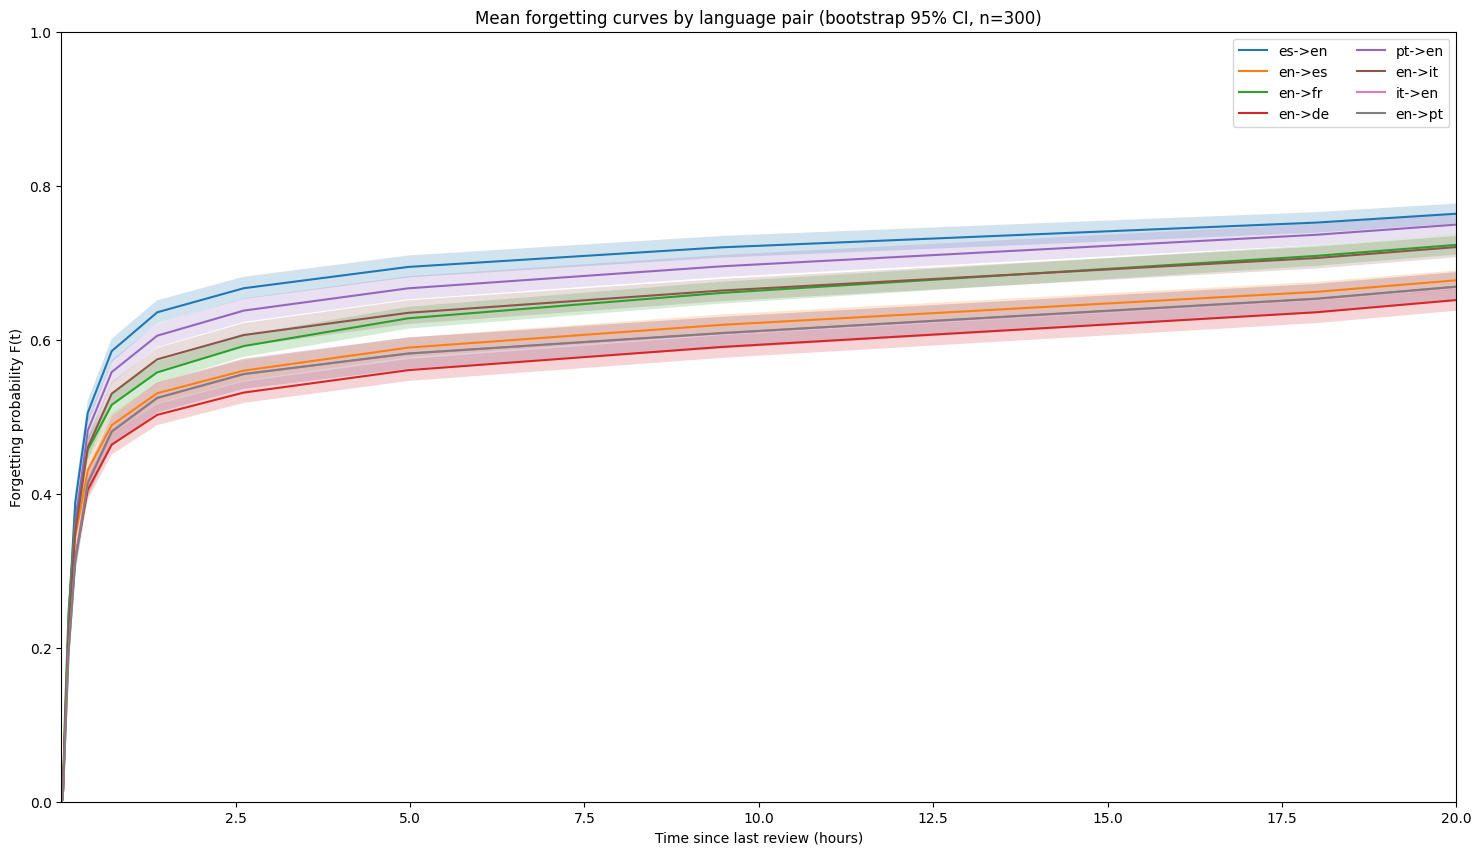

<Figure size 640x480 with 0 Axes>

In [ ]:
K = 8
lang_pairs = (
    ep_valid["lang_pair"]
    .astype(str)
    .value_counts()
    .head(K)
    .index
    .tolist()
)

def get_F_curve_fast(model, x_static: dict, feature_cols: list[str], bin_edges: np.ndarray, max_bin=None):
    if max_bin is None:
        max_bin = len(bin_edges) - 1

    # 构造 time_bin=1..T 的特征矩阵
    rows = []
    for tb in range(1, max_bin + 1):
        r = dict(x_static)
        r["time_bin"] = tb
        rows.append(r)

    X = pd.DataFrame(rows)[feature_cols]
    h = model.predict_proba(X)[:, 1]        
    S = np.cumprod(1.0 - h)                
    F = 1.0 - S                            
    t_hours = bin_edges[1:max_bin + 1]      
    return t_hours, F


def mean_curve_with_bootstrap_ci(
    model,
    ep_df: pd.DataFrame,
    feature_cols: list[str],
    bin_edges: np.ndarray,
    lang_pair_value: str,
    n_episodes: int = 300,
    n_boot: int = 300,
    ci: float = 0.95,
    random_seed: int = 42,
):
    rng = np.random.default_rng(random_seed)

    # 抽样 episodes（来自验证集，避免泄漏；也可换成 ep_train 看拟合）
    ep_sample = ep_df.sample(n=min(n_episodes, len(ep_df)), replace=False, random_state=random_seed)

    # 计算每个 episode 的 F(t)
    T = len(bin_edges) - 1
    F_mat = np.zeros((len(ep_sample), T), dtype=np.float32)

    for i, (_, row) in enumerate(ep_sample.iterrows()):
        x = row[FEATURE_COLS].to_dict()
        x["lang_pair"] = lang_pair_value
        t, F = get_F_curve_fast(model, x, feature_cols, bin_edges, max_bin=T)
        F_mat[i, :] = F.astype(np.float32)

    # 平均曲线
    mean_F = F_mat.mean(axis=0)

    # bootstrap CI（对 episodes 重采样）
    alpha = (1.0 - ci) / 2.0
    boot_means = np.zeros((n_boot, T), dtype=np.float32)
    n = F_mat.shape[0]
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)   # 有放回抽样 episode
        boot_means[b, :] = F_mat[idx, :].mean(axis=0)

    lo = np.quantile(boot_means, alpha, axis=0)
    hi = np.quantile(boot_means, 1.0 - alpha, axis=0)

    return t, mean_F, lo, hi


N_EP = 300     
N_BOOT = 300   
CI = 0.95
X_MIN_HOURS = 0.00125  

plt.figure(figsize=(18, 10))

for lp in lang_pairs:
    t, mean_F, lo, hi = mean_curve_with_bootstrap_ci(
        hazard_model,
        ep_valid,
        pp_feature_cols,
        bin_edges,
        lang_pair_value=lp,
        n_episodes=N_EP,
        n_boot=N_BOOT,
        ci=CI,
        random_seed=42,
    )

    mask = t >= X_MIN_HOURS
    plt.plot(t[mask], mean_F[mask], label=str(lp))
    plt.fill_between(t[mask], lo[mask], hi[mask], alpha=0.2)



plt.xlim(X_MIN_HOURS, 20)


plt.ylim(0, 1)
plt.xlabel("Time since last review (hours)")
plt.ylabel("Forgetting probability F(t)")
plt.title(f"Mean forgetting curves by language pair (bootstrap {int(CI*100)}% CI, n={N_EP})")
plt.legend(ncol=2)
plt.show()
plt.savefig("languagege_crurves.pdf", bbox_inches="tight")